# Model
## AST
### use ViT with Spectrogram

In [2]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
import pyedflib
import librosa
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from transformers import ASTModel, ASTConfig

c:\V89\.venv\Lib\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
c:\V89\.venv\Lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
c:\V89\.venv\Lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import librosa
import pyedflib
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from transformers import ASTModel, ASTConfig, ASTFeatureExtractor
import warnings
warnings.filterwarnings('ignore')

In [11]:
# ==== CONFIG ====
CSV_PATH = r"C:\V89\Snore_Apnea_Analyze\EDF_RML\data_csv\respiratory_binary_v2.csv"
EDF_ROOT = Path(r"C:\V89\data2")
TARGET_SR = 16000
SEGMENT_DURATION = 5.0
BATCH_SIZE = 4
EPOCHS = 5
SAVE_DIR = r"C:\V89\model_AST"
os.makedirs(SAVE_DIR, exist_ok=True)

## Data Loader

In [12]:
# ==== Seed & Device ====
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == "cuda":
    print(f"GPU: {torch.cuda.get_device_name()}")

Using device: cuda
GPU: NVIDIA GeForce RTX 4060


In [13]:
class SnoreApneaASTDataset(Dataset):
    def __init__(self, df, edf_root, target_sr=16000, segment_duration=5.0):
        self.df = df.reset_index(drop=True)
        self.edf_root = Path(edf_root)
        self.target_sr = target_sr
        self.segment_duration = segment_duration

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        edf_path = self.edf_root / f"{row['patient_id']:08d}-100507[{row['segment_index']+1:03d}].edf"
        label = int(row["label"])

        with pyedflib.EdfReader(str(edf_path)) as f:
            sig_labels = f.getSignalLabels()
            snore_signal = f.readSignal(sig_labels.index("Snore")).astype(np.float32)
            sr = f.getSampleFrequency(sig_labels.index("Snore"))

        if sr != self.target_sr:
            snore_signal = librosa.resample(snore_signal, orig_sr=sr, target_sr=self.target_sr)

        samples = int(self.segment_duration * self.target_sr)
        if len(snore_signal) < samples:
            snore_signal = np.pad(snore_signal, (0, samples - len(snore_signal)))
        else:
            snore_signal = snore_signal[:samples]

        return torch.tensor(snore_signal), torch.tensor(label)

In [ ]:
class ASTClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        model_name = "  -10-10-0.4593"
        self.feature_extractor = ASTFeatureExtractor.from_pretrained(model_name)
        self.ast = ASTModel.from_pretrained(model_name)

        hidden_size = self.ast.config.hidden_size
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    def forward(self, raw_waveforms):
        inputs = self.feature_extractor(
            raw_waveforms.cpu().numpy(),
            sampling_rate=16000,
            return_tensors="pt",
            padding=True
        ).to(raw_waveforms.device)

        outputs = self.ast(**inputs)
        pooled = outputs.pooler_output
        logits = self.classifier(pooled)
        return logits

In [15]:
# ==== LOAD DATA ====
df = pd.read_csv(CSV_PATH)
df['label'] = df['type'].map({'Normal': 0, 'Apnea': 1})  # binary
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

In [16]:
# ==== DATA LOADERS ====
train_dataset = SnoreApneaASTDataset(train_df, EDF_ROOT)
val_dataset = SnoreApneaASTDataset(val_df, EDF_ROOT)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# ==== CLASS WEIGHTS ====
labels_np = train_df['label'].values
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels_np), y=labels_np)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
print("Class counts:", np.bincount(labels_np))
print("Class weights:", class_weights_tensor)

Class counts: [730 406]
Class weights: tensor([0.7781, 1.3990], device='cuda:0')


In [17]:
from sklearn.metrics import f1_score

# ==== TRAINING ====
model = ASTClassifier().to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=1e-5)  # lower LR for transformer

for epoch in range(EPOCHS):
    # ----- TRAIN -----
    model.train()
    train_correct, train_total, train_loss = 0, 0, 0
    train_true, train_pred = [], []

    for waveforms, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        waveforms, labels = waveforms.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(waveforms)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        # metrics
        train_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)
        train_true.extend(labels.cpu().numpy())
        train_pred.extend(preds.cpu().numpy())

    train_acc = train_correct / train_total
    train_f1 = f1_score(train_true, train_pred, average="macro")

    # ----- VALIDATION -----
    model.eval()
    val_correct, val_total, val_loss = 0, 0, 0
    val_true, val_pred = [], []

    with torch.no_grad():
        for waveforms, labels in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            waveforms, labels = waveforms.to(device), labels.to(device)
            logits = model(waveforms)
            loss = criterion(logits, labels)

            # metrics
            val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
            val_true.extend(labels.cpu().numpy())
            val_pred.extend(preds.cpu().numpy())

    val_acc = val_correct / val_total
    val_f1 = f1_score(val_true, val_pred, average="macro")

    # ----- PRINT RESULTS -----
    print(f"Epoch {epoch+1}/{EPOCHS} "
          f"Train Loss: {train_loss/len(train_loader):.4f} "
          f"Train Acc: {train_acc:.4f} "
          f"Train F1: {train_f1:.4f} | "
          f"Val Loss: {val_loss/len(val_loader):.4f} "
          f"Val Acc: {val_acc:.4f} "
          f"Val F1: {val_f1:.4f}")


Epoch 1 [Val]: 100%|██████████| 71/71 [09:43<00:00,  8.21s/it]


Epoch 1/5 Train Loss: 0.5294 Train Acc: 0.7121 Train F1: 0.6875 | Val Loss: 0.4381 Val Acc: 0.8134 Val F1: 0.7610


Epoch 2 [Val]: 100%|██████████| 71/71 [09:31<00:00,  8.05s/it]


Epoch 2/5 Train Loss: 0.4644 Train Acc: 0.7782 Train F1: 0.7457 | Val Loss: 0.4396 Val Acc: 0.8134 Val F1: 0.7610


Epoch 3 [Val]: 100%|██████████| 71/71 [09:55<00:00,  8.39s/it]


Epoch 3/5 Train Loss: 0.4424 Train Acc: 0.7905 Train F1: 0.7531 | Val Loss: 0.4153 Val Acc: 0.8134 Val F1: 0.7610


Epoch 4 [Val]: 100%|██████████| 71/71 [11:08<00:00,  9.41s/it]


Epoch 4/5 Train Loss: 0.4407 Train Acc: 0.7870 Train F1: 0.7517 | Val Loss: 0.4358 Val Acc: 0.8134 Val F1: 0.7610


Epoch 5 [Val]: 100%|██████████| 71/71 [11:16<00:00,  9.53s/it]

Epoch 5/5 Train Loss: 0.4376 Train Acc: 0.7958 Train F1: 0.7557 | Val Loss: 0.4318 Val Acc: 0.8134 Val F1: 0.7610


In [18]:
model_path = os.path.join(SAVE_DIR, "model_weights_AST_V4.pth")
torch.save(model.state_dict(), model_path)
print(f"✅ Model weights saved to {model_path}")

✅ Model weights saved to C:\V89\model_AST\model_weights_AST_V4.pth


# Eval

Evaluating: 100%|██████████| 71/71 [11:26<00:00,  9.67s/it]




CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      Normal       0.77      1.00      0.87       182
       Apnea       1.00      0.48      0.65       102

    accuracy                           0.81       284
   macro avg       0.89      0.74      0.76       284
weighted avg       0.86      0.81      0.79       284



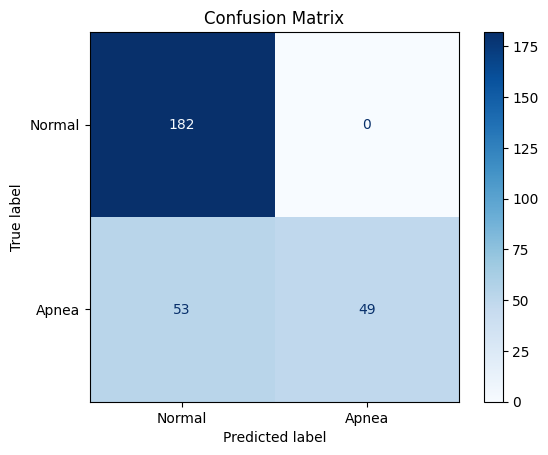

In [19]:
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for waveforms, labels in tqdm(val_loader, desc="Evaluating"):
        waveforms, labels = waveforms.to(device), labels.to(device)
        logits = model(waveforms)
        preds = torch.argmax(logits, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("\nCLASSIFICATION REPORT:")
print("="*40)
print(classification_report(y_true, y_pred, target_names=["Normal", "Apnea"]))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Apnea"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

Evaluating: 100%|██████████| 71/71 [10:46<00:00,  9.11s/it]


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      Normal       0.77      1.00      0.87       182
       Apnea       1.00      0.48      0.65       102

    accuracy                           0.81       284
   macro avg       0.89      0.74      0.76       284
weighted avg       0.86      0.81      0.79       284



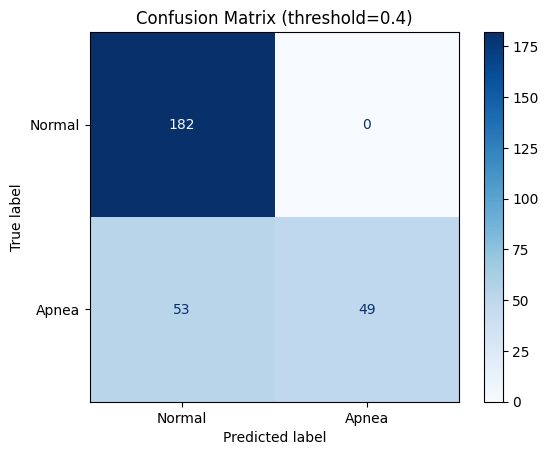

In [21]:
model.eval()
y_true, y_pred = [], []
threshold = 0.4  # <<=== เปลี่ยนค่า threshold ได้ตรงนี้

with torch.no_grad():
    for waveforms, labels in tqdm(val_loader, desc="Evaluating"):
        waveforms, labels = waveforms.to(device), labels.to(device)
        logits = model(waveforms)
        
        # ถ้าเป็น binary classification
        probs = torch.softmax(logits, dim=1)[:, 1]  # ความน่าจะเป็น class "Apnea"
        preds = (probs >= threshold).long()  # กำหนด threshold เอง

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("\nCLASSIFICATION REPORT:")
print("="*40)
print(classification_report(y_true, y_pred, target_names=["Normal", "Apnea"]))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Apnea"])
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix (threshold={threshold})")
plt.show()
